# TV Titanic

TV Titanic is a very basic introductory exploration of the Titanic kaggle competition.
The [ship prefix](https://en.wikipedia.org/wiki/Ship_prefix) *TV* is used for *Training Vessel* - an apt name for this exploration.

This journey of the TV Titanic uses pandas and sklearn and steps from Booz Allen Hamilton's [Field Guide to Data Science](https://www.boozallen.com/s/insight/publication/field-guide-to-data-science.html) as follows:
1. Collect - download and load the dataset
2. Describe - summarize, clean and normalize the dataset
3. Discover - explore and discover relationships in the dataset
4. Predict - build and test a predictive model for survivors
5. Advise - buy a ticket? :o Actually just choose a model and submit results.

The goal is to submit results in a 418 x 2 csv containing PassengerId, and Survived as well as this workbook which contains a predictive kernel.

In [1]:
%matplotlib inline
import collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, \
    recall_score, f1_score, roc_curve, roc_auc_score, auc
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.learning_curve import learning_curve
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore') # avoid showing seaborn warnings
import sys
print(sys.version)

3.6.6 |Anaconda custom (64-bit)| (default, Jun 28 2018, 11:27:44) [MSC v.1900 64 bit (AMD64)]


C:\Users\AFMS\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\AFMS\Anaconda3\lib\site-packages\sklearn\learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


## 1. Collect - download and load the dataset

Download data from [kaggle.com/c/titanic/data](https://www.kaggle.com/c/titanic/data).  

There are 3 files:

- train.csv - used to build your machine learning models
- test.csv -  used to see how well your model performs on unseen data
- gender_submission.csv - example of a submission file that assumes only female passengers survive.

Display shape, type and head content of each dataset.  
Combine the train and test datasets for cleaning.

In [2]:
trn = pd.read_csv('../input/train.csv', index_col=False)
print(trn.shape)
print(trn.dtypes)
trn.head(2)

(891, 12)
PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [3]:
tst = pd.read_csv('../input/test.csv', index_col=False)
print(tst.shape)
print(tst.dtypes)
tst.head(2)

(418, 11)
PassengerId      int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S


In [4]:
df = pd.concat((trn,tst), ignore_index=True)
print(df.shape)
print(df.dtypes)
df.tail(2)

(1309, 12)
Age            float64
Cabin           object
Embarked        object
Fare           float64
Name            object
Parch            int64
PassengerId      int64
Pclass           int64
Sex             object
SibSp            int64
Survived       float64
Ticket          object
dtype: object


,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
1307,NaN,NaN,S,8.0500,"Ware, Mr. Frederick",0,1308,3,male,0,NaN,359309
1308,NaN,NaN,C,22.3583,"Peter, Master. Michael J",1,1309,3,male,1,NaN,2668


## 2. Describe - summarize, clean and normalize the dataset

Make all text lowercase.
Explore each field and determine how to best clean and normalize it.
Explore cleaned dataset for relationships.

In [5]:
df = df.applymap(lambda s:s.lower() if type(s) == str else s)
df.head(2)

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,s,7.2500,"braund, mr. owen harris",0,1,3,male,1,0.0,a/5 21171
1,38.0,c85,c,71.2833,"cumings, mrs. john bradley (florence briggs th...",0,2,1,female,1,1.0,pc 17599


### PassengerId
Ensure sure there are no missing values before assigning this as an index. 
Pandas did load this file as int64 so we alread know there are no NaN values.
Make sure there are no duplicates and no zero values.

In [6]:
df.PassengerId.describe() # note, min is 1 so there are no zeros, max is 1309 so they are probably numbered sequentially

count    1309.000000
mean      655.000000
std       378.020061
min         1.000000
25%       328.000000
50%       655.000000
75%       982.000000
max      1309.000000
Name: PassengerId, dtype: float64

In [7]:
# count duplicates https://stackoverflow.com/a/35584675
df.groupby(['PassengerId'],as_index=False).size().sort_values().tail(2)

PassengerId
449     1
1309    1
dtype: int64

there are no duplicates

In [8]:
df = df.set_index('PassengerId')
df.head(2)

,Age,Cabin,Embarked,Fare,Name,Parch,Pclass,Sex,SibSp,Survived,Ticket
PassengerId,,,,,,,,,,,
1,22.0,NaN,s,7.2500,"braund, mr. owen harris",0,3,male,1,0.0,a/5 21171
2,38.0,c85,c,71.2833,"cumings, mrs. john bradley (florence briggs th...",0,1,female,1,1.0,pc 17599


### Survived
Survival: 0 = No, 1 = Yes, NaN = None

Leave this as is.  When we merged the dataframes this became a float so that the test values are NaN.

In [9]:
df.Survived.value_counts()

0.0    549
1.0    342
Name: Survived, dtype: int64

### Pclass
Ticket class: 1 = 1st, 2 = 2nd, 3 = 3rd

In [10]:
df.Pclass.value_counts()

3    709
1    323
2    277
Name: Pclass, dtype: int64

In [11]:
df.Pclass.value_counts().sum()

1309

In [12]:
def as_norm_class(v):
    if v == 1:
        return 1.0
    elif v == 2:
        return 0.5
    else:
        return 0.0
df['pclass'] = df.Pclass.map(as_norm_class)
df = df.drop('Pclass', axis=1)
df.head(2)

,Age,Cabin,Embarked,Fare,Name,Parch,Sex,SibSp,Survived,Ticket,pclass
PassengerId,,,,,,,,,,,
1,22.0,NaN,s,7.2500,"braund, mr. owen harris",0,male,1,0.0,a/5 21171,0.0
2,38.0,c85,c,71.2833,"cumings, mrs. john bradley (florence briggs th...",0,female,1,1.0,pc 17599,1.0


### Name
Check for missing or duplicate values.  What are the longest and shortest values?

In [13]:
df.Name.describe() 

count                     1309
unique                    1307
top       connolly, miss. kate
freq                         2
Name: Name, dtype: object

Looks like there are two Jim Kellys - are they the same person?

In [14]:
df[df.Name == 'kelly, mr. james']

,Age,Cabin,Embarked,Fare,Name,Parch,Sex,SibSp,Survived,Ticket,pclass
PassengerId,,,,,,,,,,,
697,44.0,NaN,s,8.0500,"kelly, mr. james",0,male,0,0.0,363592,0.0
892,34.5,NaN,q,7.8292,"kelly, mr. james",0,male,0,NaN,330911,0.0


No.  They look like different people with the same name.

In [15]:
df.Name.str.len().sort_values().head(2)

PassengerId
693    12
827    12
Name: Name, dtype: int64

The min length name is 12 - so there are no null values.
Let's look at the shortest names.

In [16]:
df[df.Name.str.len()==12]

,Age,Cabin,Embarked,Fare,Name,Parch,Sex,SibSp,Survived,Ticket,pclass
PassengerId,,,,,,,,,,,
693,NaN,NaN,s,56.4958,"lam, mr. ali",0,male,0,1.0,1601,0.0
827,NaN,NaN,s,56.4958,"lam, mr. len",0,male,0,0.0,1601,0.0


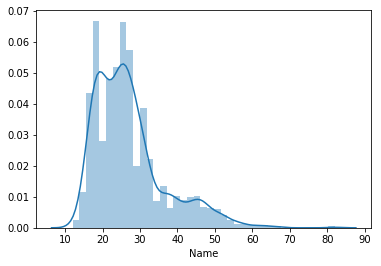

In [17]:
g = sns.distplot(df.Name.str.len().sort_values()) # get an idea of name lengths

There is a tail of really long names.  What is going on there?

In [18]:
for name in df[df.Name.str.len()>55].Name.values:
    print(name)

asplund, mrs. carl oscar (selma augusta emilia johansson)
turpin, mrs. william john robert (dorothy ann wonnacott)
penasco y castellana, mrs. victor de satode (maria josefa perez de soto y vallejo)
spedden, mrs. frederic oakley (margaretta corning stone)
phillips, miss. kate florence ("mrs kate louise phillips marshall")
duff gordon, lady. (lucille christiana sutherland) ("mrs morgan")
andersson, mrs. anders johan (alfrida konstantia brogren)
brown, mrs. thomas william solomon (elizabeth catherine ford)
rothes, the countess. of (lucy noel martha dyer-edwards)
dyker, mrs. adolf fredrik (anna elisabeth judith andersson)
cassebeer, mrs. henry arthur jr (eleanor genevieve fosdick)
marvin, mrs. daniel warner (mary graham carmichael farquarson)
crosby, mrs. edward gifford (catherine elizabeth halstead)
cardeza, mrs. james warburton martinez (charlotte wardle drake)
frolicher-stehli, mrs. maxmillian (margaretha emerentia stehli)


These names look legitimate.
Looks like there are combinations of maried names, titles, maiden names and nicknames all with thin the name field.

Normalize the name length to a variable. It may be related.  
The longest names abouve look like the belong mostly to married women.

In [19]:
maxv = df.Name.str.len().max()
minv = df.Name.str.len().min()
df['name_length'] = df.Name.map(lambda v: (len(str(v))-minv)/(maxv-minv))
df.drop('Name', axis=1, inplace=True)
df.head(2)

,Age,Cabin,Embarked,Fare,Parch,Sex,SibSp,Survived,Ticket,pclass,name_length
PassengerId,,,,,,,,,,,
1,22.0,NaN,s,7.2500,0,male,1,0.0,a/5 21171,0.0,0.157143
2,38.0,c85,c,71.2833,0,female,1,1.0,pc 17599,1.0,0.557143


### Sex
This can be mapped to a boolean,  Let's choose male as True.

In [20]:
df.Sex.describe()

count     1309
unique       2
top       male
freq       843
Name: Sex, dtype: object

In [21]:
df['sex_male'] = df.Sex.map(lambda v: 1 if v == 'male' else 0)
df = df.drop(['Sex'], axis=1)
df.head(2)

,Age,Cabin,Embarked,Fare,Parch,SibSp,Survived,Ticket,pclass,name_length,sex_male
PassengerId,,,,,,,,,,,
1,22.0,NaN,s,7.2500,0,1,0.0,a/5 21171,0.0,0.157143,1
2,38.0,c85,c,71.2833,0,1,1.0,pc 17599,1.0,0.557143,0


### Age

In [22]:
df.Age.isnull().values.sum()

263

There are 263 records with no age.  Replace these wih the mean age.  Then normalize age.

In [23]:
mean = df.Age[~df.Age.isnull()].mean()
minv = df.Age.min()
maxv = df.Age.max()
print(mean, minv, maxv)

29.881137667304014 0.17 80.0


In [24]:
df['age'] = df.Age.fillna(mean)
df['age'] = df['age'].map(lambda v: (v-minv)/(maxv-minv))

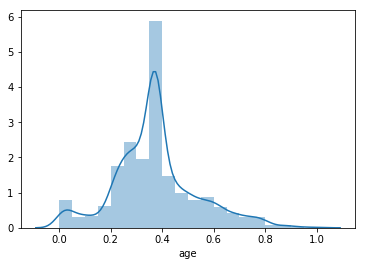

In [25]:
sns.distplot(df.age, bins=np.arange(0.0, 1.0, 0.05))

In [26]:
df = df.drop(['Age'], axis=1)
df.head(2)

,Cabin,Embarked,Fare,Parch,SibSp,Survived,Ticket,pclass,name_length,sex_male,age
PassengerId,,,,,,,,,,,
1,NaN,s,7.2500,0,1,0.0,a/5 21171,0.0,0.157143,1,0.273456
2,c85,c,71.2833,0,1,1.0,pc 17599,1.0,0.557143,0,0.473882


### SibSp
number of siblings / spouses aboard the Titanic

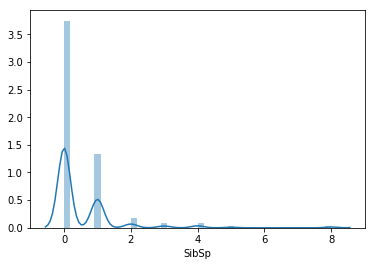

In [27]:
sns.distplot(df.SibSp)

In [28]:
df.SibSp.describe()

count    1309.000000
mean        0.498854
std         1.041658
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         8.000000
Name: SibSp, dtype: float64

In [29]:
maxv = df.SibSp.max()
df['sibsp'] = df.SibSp.map(lambda v: v/maxv)
df = df.drop(['SibSp'], axis=1)
df.head(2)

,Cabin,Embarked,Fare,Parch,Survived,Ticket,pclass,name_length,sex_male,age,sibsp
PassengerId,,,,,,,,,,,
1,NaN,s,7.2500,0,0.0,a/5 21171,0.0,0.157143,1,0.273456,0.125
2,c85,c,71.2833,0,1.0,pc 17599,1.0,0.557143,0,0.473882,0.125


### Parch
Number of parents / children aboard the Titanic.

In [30]:
df.Parch.describe()

count    1309.000000
mean        0.385027
std         0.865560
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         9.000000
Name: Parch, dtype: float64

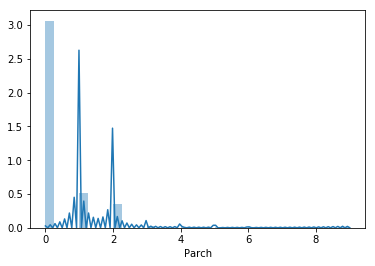

In [31]:
sns.distplot(df.Parch)

In [32]:
maxv = df.Parch.max()
df['parch'] = df.Parch.map(lambda v: v/maxv)
df = df.drop(['Parch'], axis=1)
df.head(2)

,Cabin,Embarked,Fare,Survived,Ticket,pclass,name_length,sex_male,age,sibsp,parch
PassengerId,,,,,,,,,,,
1,NaN,s,7.2500,0.0,a/5 21171,0.0,0.157143,1,0.273456,0.125,0.0
2,c85,c,71.2833,1.0,pc 17599,1.0,0.557143,0,0.473882,0.125,0.0


### Ticket
ticket number

In [33]:
df.Ticket.describe()

count         1309
unique         929
top       ca. 2343
freq            11
Name: Ticket, dtype: object

In [34]:
df.Ticket.head()

PassengerId
1           a/5 21171
2            pc 17599
3    ston/o2. 3101282
4              113803
5              373450
Name: Ticket, dtype: object

In [35]:
df.Ticket.tail()

PassengerId
1305             a.5. 3236
1306              pc 17758
1307    soton/o.q. 3101262
1308                359309
1309                  2668
Name: Ticket, dtype: object

In [36]:
df.Ticket.isnull().sum()

0

Some of these ticket numbers have text.  Flag them.

In [37]:
df['ticket_has_text'] = df.Ticket.map(lambda v: 0 if str(v).isdecimal() else 1)
df.head(2)

,Cabin,Embarked,Fare,Survived,Ticket,pclass,name_length,sex_male,age,sibsp,parch,ticket_has_text
PassengerId,,,,,,,,,,,,
1,NaN,s,7.2500,0.0,a/5 21171,0.0,0.157143,1,0.273456,0.125,0.0,1
2,c85,c,71.2833,1.0,pc 17599,1.0,0.557143,0,0.473882,0.125,0.0,1


Extract and normalize the number portion of Ticket.

In [38]:
df['ticket_number'] = df.Ticket.map(lambda v: v.split(' ')[-1])

In [39]:
for n in df.ticket_number:
    if not n.isdigit():
        print(n)

line
line
line
line


The above ticket were bought in line.  Set their ticket number to 1 past the max of the other ticket numbers.

In [40]:
df.dtypes

Cabin               object
Embarked            object
Fare               float64
Survived           float64
Ticket              object
pclass             float64
name_length        float64
sex_male             int64
age                float64
sibsp              float64
parch              float64
ticket_has_text      int64
ticket_number       object
dtype: object

In [41]:
maxv = df.ticket_number[~df.Ticket.str.contains('line')].map(int).max()
maxv

3101317

In [42]:
str(maxv+1)

'3101318'

In [43]:
df.ticket_number[df.Ticket.str.contains('line')] = str(int(maxv)+1)

In [44]:
df[df.Ticket.str.contains('line')]

,Cabin,Embarked,Fare,Survived,Ticket,pclass,name_length,sex_male,age,sibsp,parch,ticket_has_text,ticket_number
PassengerId,,,,,,,,,,,,,
180,NaN,s,0.0,0.0,line,0.0,0.100000,1,0.448829,0.0,0.0,1,3101318
272,NaN,s,0.0,1.0,line,0.0,0.228571,1,0.311036,0.0,0.0,1,3101318
303,NaN,s,0.0,0.0,line,0.0,0.271429,1,0.235876,0.0,0.0,1,3101318
598,NaN,s,0.0,0.0,line,0.0,0.100000,1,0.611675,0.0,0.0,1,3101318


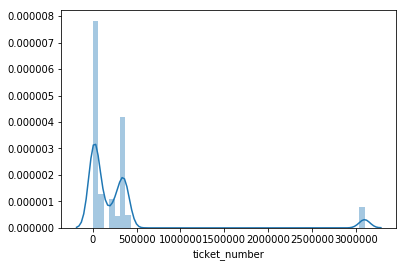

In [45]:
df['ticket_number'] = df.ticket_number.map(int)
sns.distplot(df.ticket_number)

There are some outliers on the high end.  Lets take a log and normalize that.
df.ticket_number.map(log10)

In [46]:
df['ticket_number'] = df.ticket_number.map(np.log10)

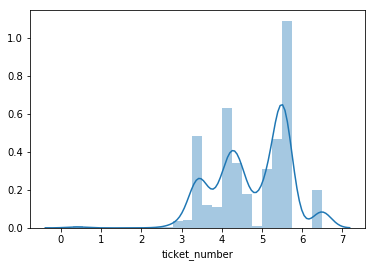

In [47]:
sns.distplot(df.ticket_number)

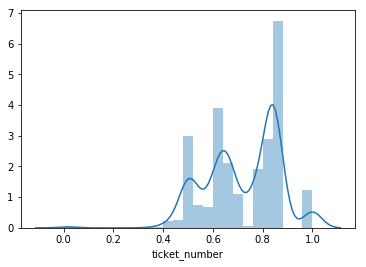

In [48]:
minv = df.ticket_number.min()
maxv = df.ticket_number.max()
df['ticket_number'] = df.ticket_number.map(lambda v: (v-minv)/(maxv-minv))
sns.distplot(df.ticket_number)

In [49]:
df.drop('Ticket', axis=1, inplace=True)
df.head(2)

,Cabin,Embarked,Fare,Survived,pclass,name_length,sex_male,age,sibsp,parch,ticket_has_text,ticket_number
PassengerId,,,,,,,,,,,,
1,NaN,s,7.2500,0.0,0.0,0.157143,1,0.273456,0.125,0.0,1,0.650141
2,c85,c,71.2833,1.0,1.0,0.557143,0,0.473882,0.125,0.0,1,0.637178


### Fare
Passenger fare

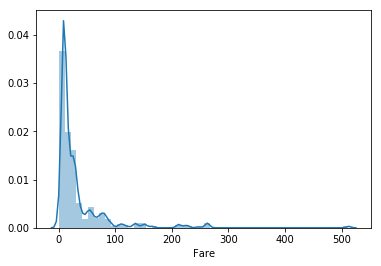

In [50]:
sns.distplot(df.Fare[df.Fare.notna()])

Whoa.  There are some realy high outling fares there.

In [51]:
df[df.Fare > 270]

,Cabin,Embarked,Fare,Survived,pclass,name_length,sex_male,age,sibsp,parch,ticket_has_text,ticket_number
PassengerId,,,,,,,,,,,,
259,NaN,c,512.3292,1.0,1.0,0.057143,0,0.436302,0.0,0.000000,1,0.637797
680,b51 b53 b55,c,512.3292,1.0,1.0,0.314286,1,0.448829,0.0,0.111111,1,0.637797
738,b101,c,512.3292,1.0,1.0,0.142857,1,0.436302,0.0,0.000000,1,0.637797
1235,b51 b53 b55,c,512.3292,NaN,1.0,0.728571,0,0.724414,0.0,0.111111,1,0.637797


Seem like legit fares - so go with them.

replace NaN fares with the mean fare

In [52]:
meanv = df.Fare.mean()
meanv

33.2954792813456

In [53]:
df.Fare[df.Fare.isna()] = meanv

In [54]:
maxv = df.Fare.max()
df['fare'] = df.Fare.map(lambda v: v/maxv)

In [55]:
df.drop('Fare', axis=1, inplace=True)
df.head(2)

,Cabin,Embarked,Survived,pclass,name_length,sex_male,age,sibsp,parch,ticket_has_text,ticket_number,fare
PassengerId,,,,,,,,,,,,
1,NaN,s,0.0,0.0,0.157143,1,0.273456,0.125,0.0,1,0.650141,0.014151
2,c85,c,1.0,1.0,0.557143,0,0.473882,0.125,0.0,1,0.637178,0.139136


### Cabin
cabin number
Hmm.  Wonder if these cabin numbers can tell us where on the ship passengers slept.
If so cabin could be a useful feature.
[encyclopedia-titanica.org/titanic-deckplans]
(https://www.encyclopedia-titanica.org/titanic-deckplans) shows a map of deckplans.
It looks like the lower decks have higher letter numbers.
Also, not having a cabin number could imply crew.  

In [56]:
df.Cabin.describe()

count             295
unique            186
top       c23 c25 c27
freq                6
Name: Cabin, dtype: object

In [57]:
df.Cabin[~df.Cabin.isnull()].head(10)

PassengerId
2             c85
4            c123
7             e46
11             g6
12           c103
22            d56
24             a6
28    c23 c25 c27
32            b78
53            d33
Name: Cabin, dtype: object

Let's normalize this data into categories between 0 and 1:

In [58]:
def as_cabin_deck(cv):
    if not isinstance(cv, str):
        return 0.0
    elif 'a' in cv:
        return 1.0
    elif 'b' in cv:
        return 0.85
    elif 'c' in cv:
        return 0.70
    elif 'd' in cv:
        return 0.55
    elif 'e' in cv:
        return 0.40
    elif 'f' in cv:
        return 0.25
    elif 'g' in cv:
        return 0.10
    else:
        return 0.0
df['cabin_deck']=df.Cabin.map(as_cabin_deck)
df = df.drop('Cabin', axis=1)
df.head(2)

,Embarked,Survived,pclass,name_length,sex_male,age,sibsp,parch,ticket_has_text,ticket_number,fare,cabin_deck
PassengerId,,,,,,,,,,,,
1,s,0.0,0.0,0.157143,1,0.273456,0.125,0.0,1,0.650141,0.014151,0.0
2,c,1.0,1.0,0.557143,0,0.473882,0.125,0.0,1,0.637178,0.139136,0.7


### Embarked
port of embarkation, C = Cherbourg, Q = Queenstown, S = Southampton

In [59]:
df.Embarked.describe()

count     1307
unique       3
top          s
freq       914
Name: Embarked, dtype: object

In [60]:
df[df.Embarked.isnull()]

,Embarked,Survived,pclass,name_length,sex_male,age,sibsp,parch,ticket_has_text,ticket_number,fare,cabin_deck
PassengerId,,,,,,,,,,,,
62,NaN,1.0,1.0,0.100000,0,0.473882,0.0,0.0,0,0.767988,0.15615,0.85
830,NaN,1.0,1.0,0.414286,0,0.774521,0.0,0.0,0,0.767988,0.15615,0.85


Let's attempt to determine where these two passengers embarked from and assign the correct port.
Neither of them had siblings or spouses with them on the Titanc.
However they are both first class.
Which port did most first class passengers embark from?

In [61]:
df[df.pclass==1.0].groupby(['Embarked'],as_index=False).size().sort_values()

Embarked
q      3
c    141
s    177
dtype: int64

Most embarked from Southampton, though Cherbourg was a close second.  Let's put one in each.

In [62]:
df.at[62,'Embarked'] = 's'
df.at[830, 'Embarked'] = 'c'
df.ix[[62,830]]

,Embarked,Survived,pclass,name_length,sex_male,age,sibsp,parch,ticket_has_text,ticket_number,fare,cabin_deck
PassengerId,,,,,,,,,,,,
62,s,1.0,1.0,0.100000,0,0.473882,0.0,0.0,0,0.767988,0.15615,0.85
830,c,1.0,1.0,0.414286,0,0.774521,0.0,0.0,0,0.767988,0.15615,0.85


In [63]:
df[df.pclass==1].groupby(['Embarked'],as_index=False).size().sort_values()

Embarked
q      3
c    142
s    178
dtype: int64

In [64]:
dum = pd.get_dummies(df.Embarked)
df = pd.concat([df, dum], axis=1)
df = df.drop('Embarked', axis=1)
df.head(2)

,Survived,pclass,name_length,sex_male,age,sibsp,parch,ticket_has_text,ticket_number,fare,cabin_deck,c,q,s
PassengerId,,,,,,,,,,,,,,
1,0.0,0.0,0.157143,1,0.273456,0.125,0.0,1,0.650141,0.014151,0.0,0,0,1
2,1.0,1.0,0.557143,0,0.473882,0.125,0.0,1,0.637178,0.139136,0.7,1,0,0


Now that the data is cleaned and normalized split it back into train and test sets.

In [65]:
maxv = trn.PassengerId.max()
maxv

891

In [66]:
trn = df[df.index <= maxv]
print(trn.shape)
print(trn.dtypes)
trn.head(2)

(891, 14)
Survived           float64
pclass             float64
name_length        float64
sex_male             int64
age                float64
sibsp              float64
parch              float64
ticket_has_text      int64
ticket_number      float64
fare               float64
cabin_deck         float64
c                    uint8
q                    uint8
s                    uint8
dtype: object


,Survived,pclass,name_length,sex_male,age,sibsp,parch,ticket_has_text,ticket_number,fare,cabin_deck,c,q,s
PassengerId,,,,,,,,,,,,,,
1,0.0,0.0,0.157143,1,0.273456,0.125,0.0,1,0.650141,0.014151,0.0,0,0,1
2,1.0,1.0,0.557143,0,0.473882,0.125,0.0,1,0.637178,0.139136,0.7,1,0,0


In [67]:
trn.Survived=trn.Survived.map(int)
trn.head(2)

,Survived,pclass,name_length,sex_male,age,sibsp,parch,ticket_has_text,ticket_number,fare,cabin_deck,c,q,s
PassengerId,,,,,,,,,,,,,,
1,0,0.0,0.157143,1,0.273456,0.125,0.0,1,0.650141,0.014151,0.0,0,0,1
2,1,1.0,0.557143,0,0.473882,0.125,0.0,1,0.637178,0.139136,0.7,1,0,0


In [68]:
tst = df[df.index > maxv]
print(tst.shape)
print(tst.dtypes)
tst.head(2)

(418, 14)
Survived           float64
pclass             float64
name_length        float64
sex_male             int64
age                float64
sibsp              float64
parch              float64
ticket_has_text      int64
ticket_number      float64
fare               float64
cabin_deck         float64
c                    uint8
q                    uint8
s                    uint8
dtype: object


,Survived,pclass,name_length,sex_male,age,sibsp,parch,ticket_has_text,ticket_number,fare,cabin_deck,c,q,s
PassengerId,,,,,,,,,,,,,,
892,NaN,0.0,0.057143,1,0.430039,0.000,0.0,0,0.843012,0.015282,0.0,0,1,0
893,NaN,0.0,0.285714,0,0.586622,0.125,0.0,0,0.849558,0.013663,0.0,0,0,1


In [69]:
tst.drop('Survived', axis=1, inplace=True)
tst.head(2)

,pclass,name_length,sex_male,age,sibsp,parch,ticket_has_text,ticket_number,fare,cabin_deck,c,q,s
PassengerId,,,,,,,,,,,,,
892,0.0,0.057143,1,0.430039,0.000,0.0,0,0.843012,0.015282,0.0,0,1,0
893,0.0,0.285714,0,0.586622,0.125,0.0,0,0.849558,0.013663,0.0,0,0,1


## 3. Discover - explore and discover relationships in the dataset

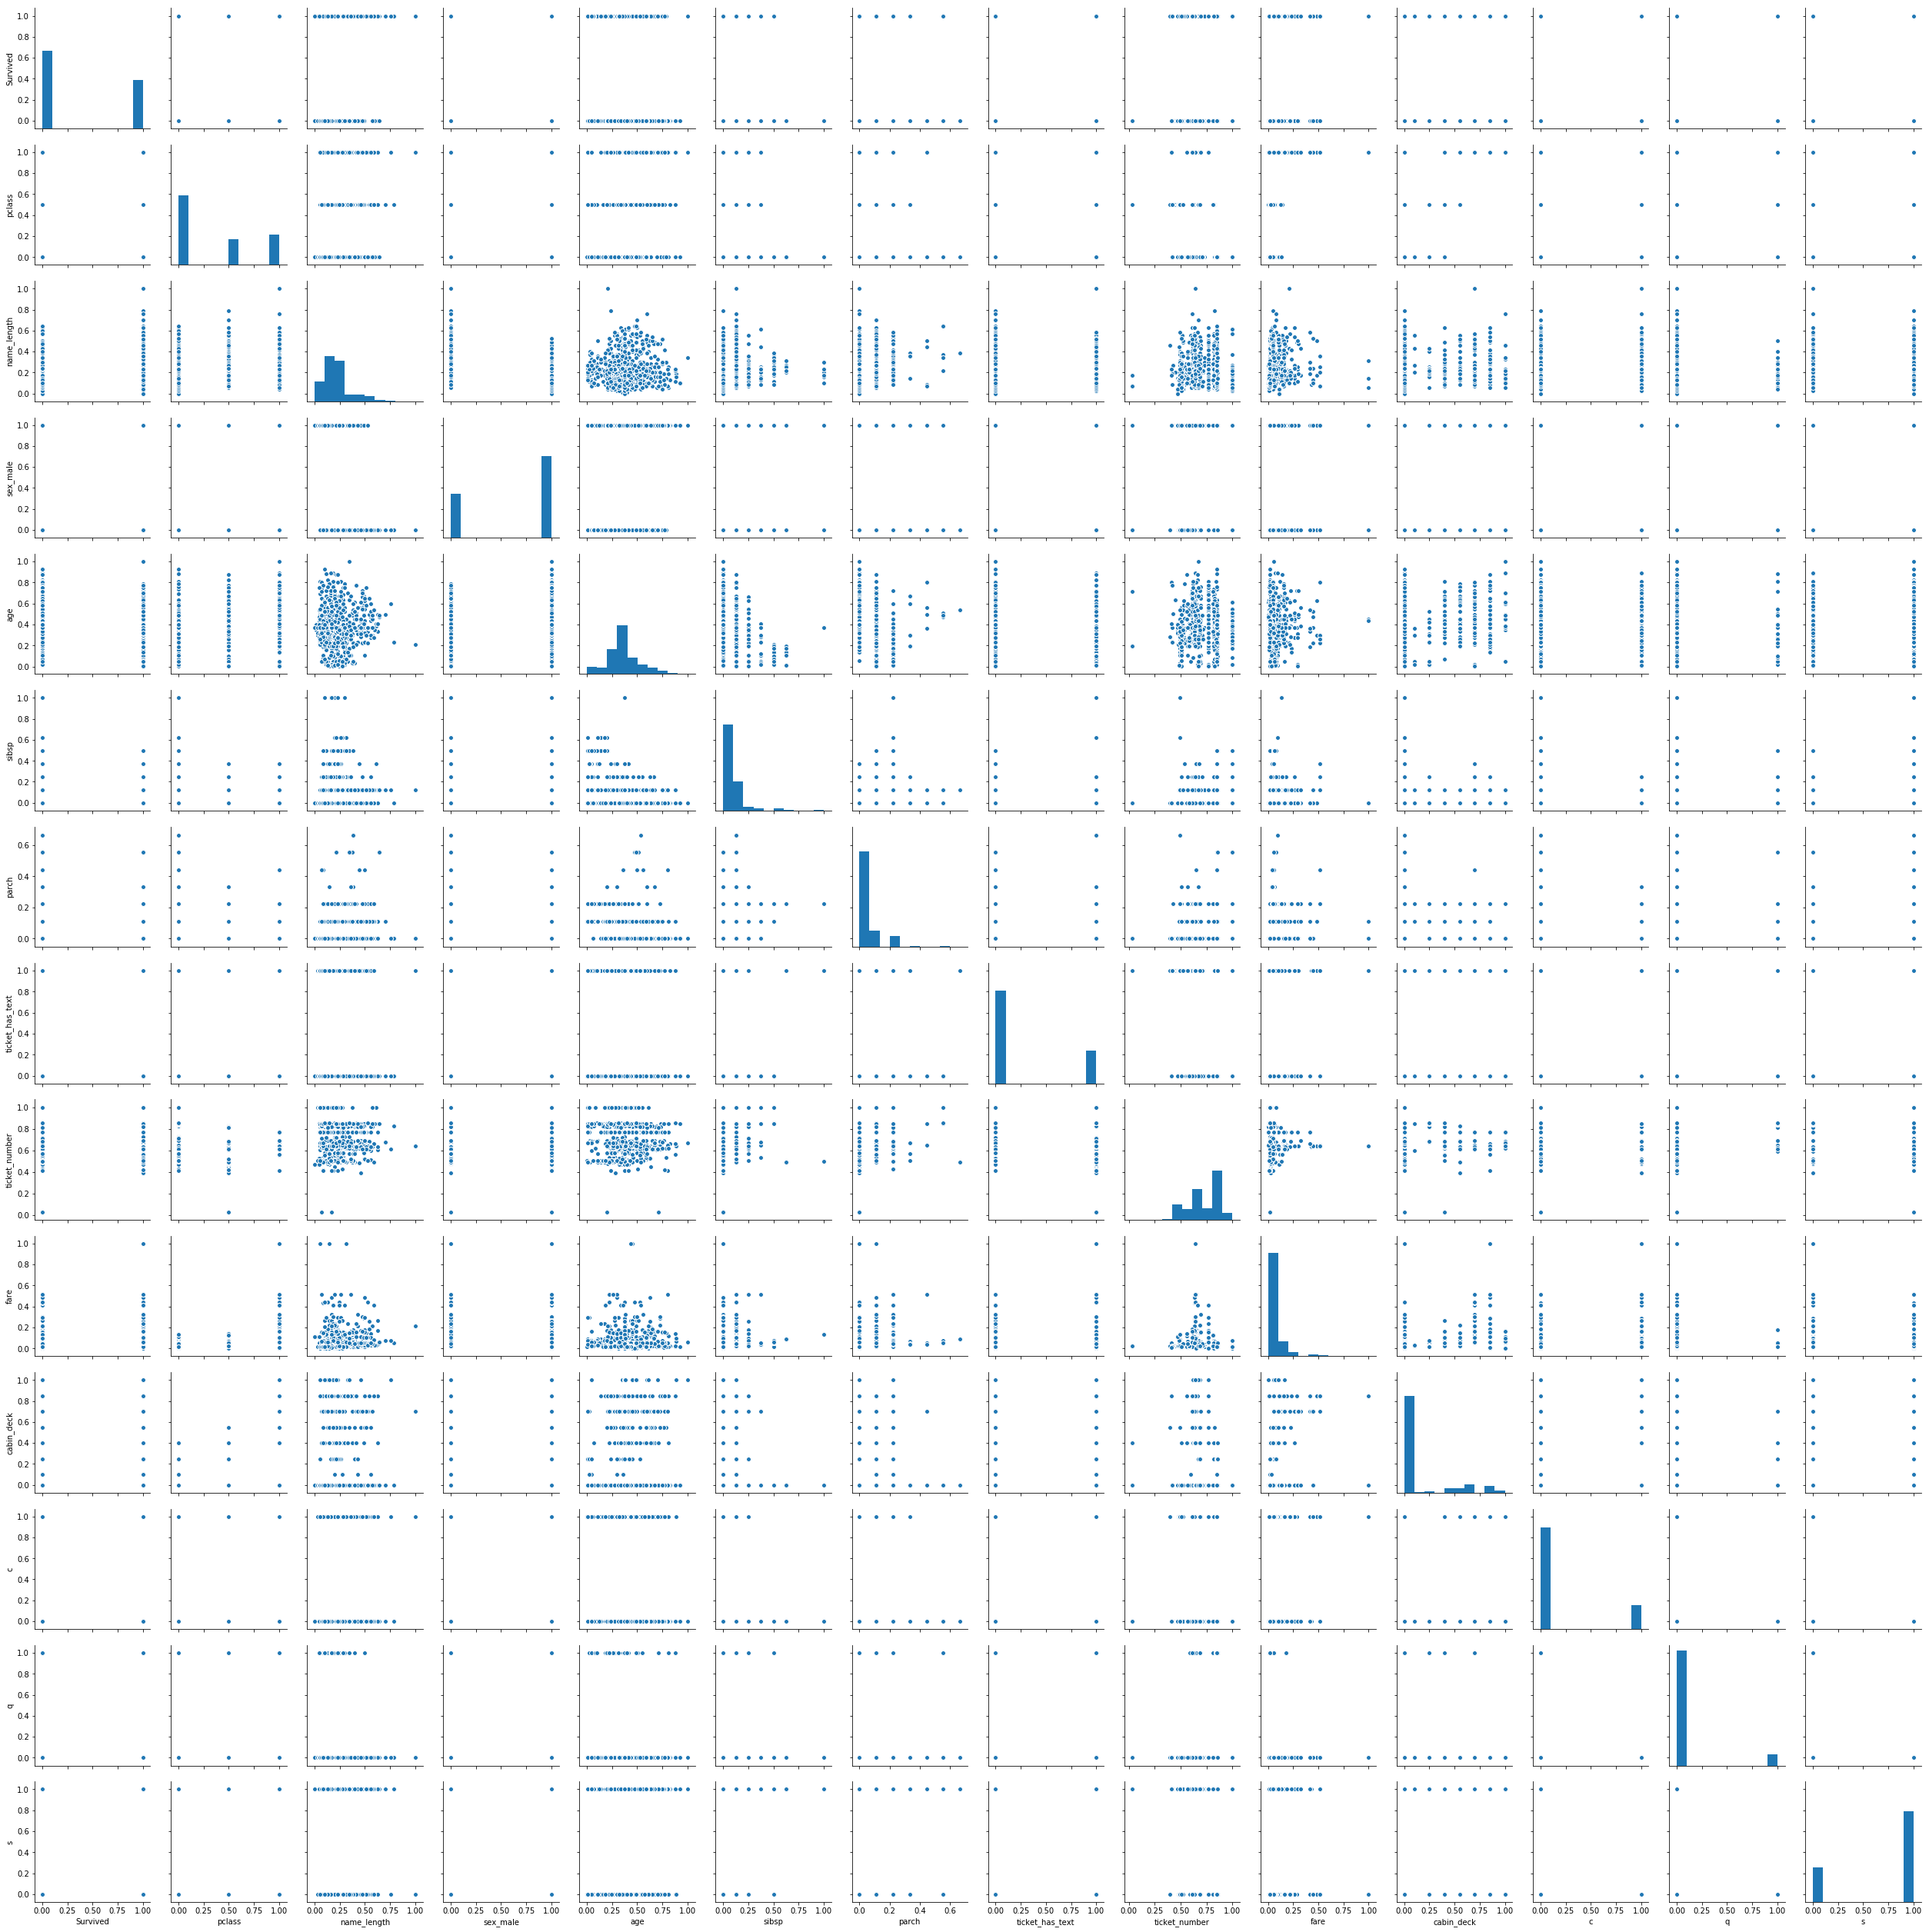

In [70]:
sns.pairplot(data=trn)

Most features appear independent of other features.  

There seems to be a very loose coorelation between age and cabin_deck.
Perhaps the upper decks had less children.  

Also, older folks seem less likely to have more siblings and spouses on board than younger ones.

## 4. Predict - build and test a predictive model for survivors

In [71]:
test_size = 0.3
random_state = 4444
np.random.seed(random_state)

algorithms = (
    LogisticRegression, 
    KNeighborsClassifier,
    GaussianNB,
    SVC,
    DecisionTreeClassifier,
    RandomForestClassifier)

algorithm_names = [a.__name__ for a in algorithms]

In [72]:
trn.head(2)

,Survived,pclass,name_length,sex_male,age,sibsp,parch,ticket_has_text,ticket_number,fare,cabin_deck,c,q,s
PassengerId,,,,,,,,,,,,,,
1,0,0.0,0.157143,1,0.273456,0.125,0.0,1,0.650141,0.014151,0.0,0,0,1
2,1,1.0,0.557143,0,0.473882,0.125,0.0,1,0.637178,0.139136,0.7,1,0,0


In [73]:
y = trn.Survived
X = trn.drop('Survived', axis=1)
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=test_size, random_state=random_state)

In [74]:
score_names = ['accuracy', 'precision', 'recall', 'f1']
def test_score(estimator, xtr, xtst, ytr, ytst):
    estimator.fit(xtr, ytr)
    yh = estimator.predict(xtst)
    acc = accuracy_score(ytst, yh)
    prc = precision_score(ytst, yh)
    rcl = recall_score(ytst, yh)
    f1= f1_score(ytst,yh)
    return acc, prc, rcl, f1

def test_scores():
    dscores = collections.defaultdict(list)
    for algorithm in algorithms:
        acc, prc, rcl, f1 = test_score(algorithm(), Xtrain, Xtest, ytrain, ytest)
        dscores['accuracy'].append(acc)
        dscores['precision'].append(prc)
        dscores['recall'].append(rcl)
        dscores['f1'].append(f1)
    return pd.DataFrame(dscores, columns = score_names, index = algorithm_names)

scores = test_scores()
scores

,accuracy,precision,recall,f1
LogisticRegression,0.761194,0.702128,0.647059,0.673469
KNeighborsClassifier,0.776119,0.776316,0.578431,0.662921
GaussianNB,0.753731,0.680000,0.666667,0.673267
SVC,0.746269,0.688889,0.607843,0.645833
DecisionTreeClassifier,0.764925,0.719101,0.627451,0.670157
RandomForestClassifier,0.779851,0.786667,0.578431,0.666667


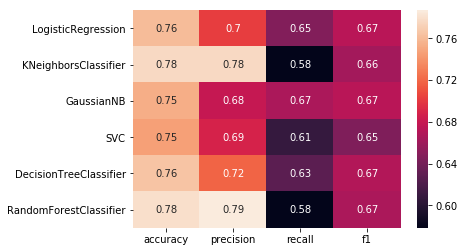

In [75]:
g = sns.heatmap(scores, annot=True)

For each of the models lets look at the Receiver Operating Characteristic (ROC) and the Area Under the Curve (AUC).

In [76]:
rocauc_names = ['false_pos_rate', 'true_pos_rate', 'auc']

def test_rocaucs(algorithms_):
    drocauc = collections.defaultdict(list)
    alg_names = []
    for algorithm in algorithms_:
        alg_names.append(algorithm.__name__)        
        estimator = algorithm()
        estimator.fit(Xtrain, ytrain)
        yh = estimator.predict(Xtest)
        false_pos_rate, true_pos_rate, thresholds = roc_curve(ytest, yh)
        a_u_c = auc(false_pos_rate, true_pos_rate)
        drocauc['false_pos_rate'].append(false_pos_rate)
        drocauc['true_pos_rate'].append(true_pos_rate)
        drocauc['auc'].append(a_u_c)
    return pd.DataFrame(drocauc, columns = rocauc_names, index = alg_names)

rocaucs = test_rocaucs(algorithms)
rocaucs

,false_pos_rate,true_pos_rate,auc
LogisticRegression,"[0.0, 0.1686746987951807, 1.0]","[0.0, 0.6470588235294118, 1.0]",0.739192
KNeighborsClassifier,"[0.0, 0.10240963855421686, 1.0]","[0.0, 0.5784313725490197, 1.0]",0.738011
GaussianNB,"[0.0, 0.1927710843373494, 1.0]","[0.0, 0.6666666666666666, 1.0]",0.736948
SVC,"[0.0, 0.1686746987951807, 1.0]","[0.0, 0.6078431372549019, 1.0]",0.719584
DecisionTreeClassifier,"[0.0, 0.14457831325301204, 1.0]","[0.0, 0.6568627450980392, 1.0]",0.756142
RandomForestClassifier,"[0.0, 0.08433734939759036, 1.0]","[0.0, 0.5686274509803921, 1.0]",0.742145


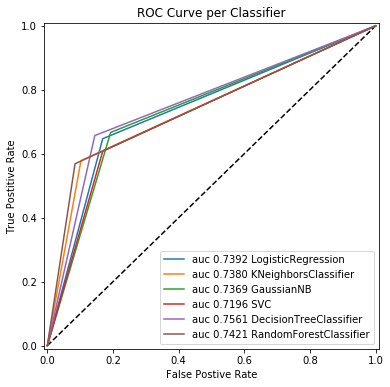

In [77]:
def plot_rocs(dfrocaucs):
    plt.figure(figsize=(6,6))
    plt.plot([0,1], [0,1], 'k--')
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.xlabel('False Postive Rate')
    plt.ylabel('True Postitive Rate')
    plt.title('ROC Curve per Classifier')
    for ir in dfrocaucs.itertuples():
        lbl = 'auc {:0.4f} {}'.format(ir[3], ir[0])
        plt.plot(ir[1], ir[2], label=lbl)
    plt.legend(loc='lower right')
    
    
plot_rocs(rocaucs)

According to ROC the DecitionTreeClassifier is performing best.  However, these classfiers tend to overfit.
The RandomForestClassifier does almost as well.  Let's go with that one.

In [78]:
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [79]:
pd.Series(clf.feature_importances_, index=X.columns).sort_values()

sibsp              0.000000
ticket_has_text    0.000000
q                  0.004771
s                  0.019059
parch              0.025769
c                  0.045769
age                0.045889
name_length        0.074417
cabin_deck         0.079960
pclass             0.080418
ticket_number      0.086583
sex_male           0.213118
fare               0.324247
dtype: float64

Fare and sex were by far the most determining factors.

## 5. Advise - buy a ticket? :o Actually just choose a model and submit results

Actually, it is probably not a good idea to buy a ticket for the Titanic.

Let's used RandomForest model against kaggle's test set.

Then save the predicted results to csv and submit them.

In [80]:
print(tst.shape)
tst.head(2)
print(tst.isna().any())

(418, 13)
pclass             False
name_length        False
sex_male           False
age                False
sibsp              False
parch              False
ticket_has_text    False
ticket_number      False
fare               False
cabin_deck         False
c                  False
q                  False
s                  False
dtype: bool


In [81]:
tst['Survived'] = clf.predict(tst)
tst.head(2)

,pclass,name_length,sex_male,age,sibsp,parch,ticket_has_text,ticket_number,fare,cabin_deck,c,q,s,Survived
PassengerId,,,,,,,,,,,,,,
892,0.0,0.057143,1,0.430039,0.000,0.0,0,0.843012,0.015282,0.0,0,1,0,0
893,0.0,0.285714,0,0.586622,0.125,0.0,0,0.849558,0.013663,0.0,0,0,1,0


In [82]:
tst[['Survived']].to_csv('submission.csv', header=True)